In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from dateutil.relativedelta import relativedelta
import datetime

#matplotlib.style.use('ggplot')

In [2]:
# Directories
OUTPUT_DIR = '../Outputs/country_clusters/'
INPUT_DIR = '../Data/country_data/'
MACRO_DIR = '../Data/macro_factors/'

# Filter by year
start_date = '2015-09-27'
end_date = '2021-01-31'

# Load Data & Clean to Weekly

## Equity ETFs

In [3]:
# Load ETF returns for Equities
equity_etfs = pd.read_csv(INPUT_DIR + 'ETF_adj_close.csv', index_col=0)
equity_etfs.index = pd.to_datetime(equity_etfs.index)

equity_etfs_w = equity_etfs.resample('W').last()
equity_rets_w = np.log(equity_etfs_w).diff()
equity_rets_w = equity_rets_w.dropna()

## Market Cap

In [4]:
# Load market cap data for countries
country_mkt_cap = pd.read_csv(INPUT_DIR + 'country_market_caps.csv',skiprows=4)
country_mkt_cap = country_mkt_cap[country_mkt_cap.columns[~country_mkt_cap.columns.isin(['Country Code', 'Indicator Name', 'Indicator Code'])]]
country_mkt_cap = country_mkt_cap.T.rename_axis('Date')
country_mkt_cap = country_mkt_cap.rename(columns=country_mkt_cap.iloc[0]).drop(country_mkt_cap.index[0])

# Only select countries in EM universe
# Remove Taiwan since it doesn't exist in the market cap data; change names for Korea, Russia, Egypt for better search
em_countries = equity_rets_w.columns.values
em_countries = np.where(em_countries=='Korea', 'Korea, Rep.', em_countries) 
em_countries = np.where(em_countries=='Russia', 'Russian Federation', em_countries) 
em_countries = np.where(em_countries=='Egypt', 'Egypt, Arab Rep.', em_countries)
em_countries = em_countries[~np.isin(em_countries, 'Taiwan')]

country_mkt_cap = country_mkt_cap[em_countries]
country_mkt_cap.index = pd.to_datetime(country_mkt_cap.index, format='%Y')
country_mkt_cap = country_mkt_cap[(country_mkt_cap.index>='2015-01-01') & (country_mkt_cap.index<=end_date)]
country_mkt_cap.rename(columns={'Korea, Rep.': 'Korea', 'Russian Federation': 'Russia', 'Egypt, Arab Rep.': 'Egypt'}, inplace=True)
country_mkt_cap = country_mkt_cap.fillna(method='ffill')
country_mkt_cap = country_mkt_cap.append(country_mkt_cap.iloc[-1])
country_mkt_cap.index = pd.date_range('2015', '2022', freq='Y')

# Make market cap df to be in weekly
new_df = pd.DataFrame(index=equity_rets_w.index)
def merge_by_year(df):
    df['year'] = list(df.index.year)
    return df

country_mkt_cap = merge_by_year(new_df).merge(merge_by_year(country_mkt_cap), on=['year'])
country_mkt_cap.index = equity_rets_w.index
del country_mkt_cap['year']

## Market ETF

In [5]:
# Market portfolio: Uses iShares MSCI EM ETF
market_etfs = pd.read_csv(INPUT_DIR + 'etf_msci_em_agg_indices.csv',skiprows=5, index_col=0)
market_etfs.columns = ['EEM ETF', 'MSCI EM']
market_etfs.index = pd.to_datetime(market_etfs.index)

# Market portfolio returns
market_rets_w = market_etfs.resample('W').last()
market_rets_w = np.log(market_rets_w).diff()
market_rets_w = market_rets_w.dropna()

market_rets_w = market_rets_w[(market_rets_w.index>=start_date) & (market_rets_w.index<=end_date)]
market_rets_w['EEM_cum_rets'] = np.exp(market_rets_w['EEM ETF'].cumsum())-1

## Country PE Ratios

In [6]:
# Load country PE ratios
country_pe = pd.read_csv(MACRO_DIR + 'world_PEratio.csv', skiprows=51)
country_pe_match = pd.read_csv(MACRO_DIR + 'world_PEratio.csv', nrows=50)
country_pe_match = country_pe_match[['Ticker', 'Country']]
country_pe_dict = country_pe_match.set_index('Ticker')['Country'].to_dict()
country_pe_dict = {k+'_Close': v for k, v in country_pe_dict.items()}

country_pe.index = country_pe['Date']
del country_pe['Date']

# Rename columns
country_pe.rename(country_pe_dict, axis=1, inplace=True)
em_countries_new = list(np.where(em_countries=='Korea, Rep.', 'Korea, Republic Of', em_countries))
for country in ['United Arab Emirates', 'Saudi Arabia', 'Egypt, Arab Rep.', 'Pakistan', 'Qatar']:
    em_countries_new.remove(country)
country_pe = country_pe[em_countries_new]
country_pe.rename(columns={'Korea, Republic Of': 'Korea', 'Russian Federation': 'Russia'}, inplace=True)

country_pe.index = pd.to_datetime(country_pe.index)
country_pe = country_pe[(country_pe.index>=start_date) & (country_pe.index<=end_date)]
# Fillna's with previous values
country_pe = country_pe.fillna(method='ffill')

# Convert to weekly
new_df = pd.DataFrame(index=equity_rets_w.index)
def merge_by_year_month(df):
    df['year'] = list(df.index.year)
    df['month'] = list(df.index.month)
    return df

country_pe = merge_by_year_month(new_df).merge(merge_by_year_month(country_pe), on=['year', 'month'])
country_pe.index = equity_rets_w.index
del country_pe['year']
del country_pe['month']

## FF

In [7]:
ff5 = pdr.famafrench.FamaFrenchReader('Emerging_5_Factors',start = '2000-01-01').read()[0]
ff_mom = pdr.famafrench.FamaFrenchReader('Emerging_MOM_Factor',start = '2000-01-01').read()[0]
ff6 = pd.concat([ff5,ff_mom],axis=1)
ff6['Date'] = ff6.index
ff6.index = pd.to_datetime(ff6['Date'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d'))
del ff6['Date']

In [8]:
ff6 = ff6[(ff6.index>=start_date) & (ff6.index<=end_date)]
ff6 = ff6[['SMB', 'HML', 'WML', 'Mkt-RF']]
ff6 = np.log(ff6/100+1)

# Purpose of the Notebook
1. Construct country factor
2. Construct portfolios from country-level factors
3. Backtest and construct performance metrics

# 1. Construct country factors
## Small cap portfolio
- Use country_mkt_cap as proxy for low capitalization countries.

## Value portfolio
- Use country_pe as proxy for value. This df contains PE ratios by country index.

## Momentum portfolio
- Calculate every week the cumulative trailing weekly returns for $t$-2 to $t$-52 and form three portfolios containing in equal numbers the highest, medium, and lowest momentum countries.

In [9]:
def calc_momentum_ret(df, window=52):
    '''
    Takes input a dataframe, containing weekly equity etf returns, and finds cumulative returns for trailing year
    + Input: df: equity_rets_w
    + Output: mom_df
    '''
    rolling_sum = df.rolling(window, closed='left').sum().dropna()
    rolling_ret_mom = np.exp(rolling_sum) - 1
    
    return rolling_ret_mom

In [10]:
mom_df = calc_momentum_ret(equity_rets_w)

## Beta portfolio
* Calculate every week the country beta against the ETF EM index (EEM) using a rolling sample of 52 weekly observations and create portfolios of lowest beta countries.

In [11]:
def calc_beta_ret(df, market_port_ret, window=52):
    # Find country beta's through rolling regression
    y = market_port_ret
    rolling_betas = {}
    for c in df.columns:
        X = sm.add_constant(df[c])
        model = RollingOLS(y, X, window)
        rolling_res = model.fit(params_only=True)
        rolling_betas[c] = rolling_res.params.dropna()
    
    # Put all beta's for every country and every date in a dataframe
    out_df = pd.DataFrame()
    for key, value in rolling_betas.items():
        col = pd.DataFrame(value[key])
        if out_df.empty:
            out_df = out_df.append(col)
        else:
            out_df = pd.concat([out_df, col], axis=1)
    
    return out_df

In [12]:
beta_df = calc_beta_ret(equity_rets_w, market_rets_w['EEM ETF'])

# 2. Construct portfolios from country-level factors

In [13]:
def construct_factor(df_factor_measure, df_return_all, ascending):
    '''
    + Inputs: df_factor_measure is the factor df; df_return_all is the returns df
    + Outputs: df_factor_ret is the returns on the factor portfolio; df_port is the long-short positions
    '''
    
    df_rank = df_factor_measure.rank(axis=1, ascending=ascending, pct=True)

    df_pos = df_rank.applymap(lambda x:1 if x <= 1/3 else 0)
    df_neg = df_rank.applymap(lambda x:-1 if x > 2/3 else 0)
    
    df_return = df_return_all.loc[df_factor_measure.index, df_factor_measure.columns]

    df_pos_ret_country = df_pos.multiply(df_return).div(df_pos.sum(axis=1), axis=0)
    df_pos_ret = df_pos_ret_country.sum(axis=1)
    
    df_neg_ret_country = df_neg.multiply(df_return).div(-df_neg.sum(axis=1), axis=0)
    df_neg_ret = df_neg_ret_country.sum(axis=1)
    
    df_factor_ret = df_pos_ret + df_neg_ret
    df_port = df_pos + df_neg
    
    #df_factor_cum_ret = np.exp(df_factor_ret.cumsum()) - 1
    
    return df_factor_ret, df_port

In [14]:
small_cap_ret, small_cap_port = construct_factor(country_mkt_cap, equity_rets_w, ascending=False)
value_ret, value_port = construct_factor(country_pe, equity_rets_w, ascending=False)
mom_ret, mom_port = construct_factor(mom_df, equity_rets_w, ascending=True)
low_beta_ret, low_beta_port = construct_factor(beta_df, equity_rets_w, ascending=False)

In [15]:
# Create a single df of all returns
all_port_rets = pd.concat([small_cap_ret, value_ret, mom_ret, low_beta_ret, market_rets_w['EEM ETF']], axis=1)
all_port_rets.columns = ['small_cap', 'value', 'momentum', 'low_beta', 'market']

# 3. Performance

In [21]:
# Calculate cumulative returns
def calc_cum_returns(df, log_ret = True):
    '''
    Computes cumulative returns either from simple returns or log returns
    + Input: df dataframe containing return series
    '''
    if log_ret == False:
        df = np.log(df + 1)
    
    df_ = df.copy()
    df_ = df_.dropna()
    df_ = np.exp(df_.cumsum()) - 1
    df_.columns = df_.columns.map(lambda x : x+'_cum_ret')
    return df_

# Generate performance assessment statistics
def calc_performance(rets_series, log_ret = True, time = 52):
    '''
    Generates performance metrics for portfolio or market
    + Input: return series (in log returns)
    + Output: mean annualized returns, SR, volatility
    '''
    if log_ret == False:
        rets_series = np.log(rets_series + 1)
    
    perf_df = pd.DataFrame(rets_series)
    perf_df.columns = ['returns']
    
    # Compute mean return, annualized
    def calc_mean_return(df, column):
        mean_log_return = np.mean(df[column]) 
        # Convert back to simple returns
        mean_return_annualized = (np.exp(mean_log_return) - 1) * time
        return mean_return_annualized
    
    # Compute volatility, annualized
    def calc_vol(df, column):
        std_annualized = df[column].std() * np.sqrt(time)
        return std_annualized
    
    # Compute SR, annualized
    def calc_sharpe_ratio(df, column):
        mean_ret = calc_mean_return(df, column)
        std_ = calc_vol(df, column)
        sr_annualized = (mean_ret/std_) * np.sqrt(time)
        return sr_annualized
    
    # Compute skewness and kurtosis
    def calc_skewness_kurtosis(df, column):
        skewness = df[column].skew()
        kurtosis = df[column].kurtosis()
        return skewness, kurtosis

    # Compute max drawdown 
    def calc_max_drawdown(df, column):
        # Calculate using simple returns
        returns = np.exp(df[column])-1
        cum_returns = (1 + returns).cumprod()
        drawdown = 1 - cum_returns.div(cum_returns.cummax())
        max_drawdown = np.max(drawdown.expanding().max())
        max_drawdown_date = (drawdown.expanding().max().idxmax()).strftime('%Y-%m-%d')
        return max_drawdown, max_drawdown_date
    
    # Compute all metrics for portfolio
    mean_return_ann = calc_mean_return(perf_df, 'returns')
    std_ann = calc_vol(perf_df, 'returns')
    sr_ann = calc_sharpe_ratio(perf_df, 'returns')
    skewness, kurtosis = calc_skewness_kurtosis(perf_df, 'returns')
    max_drawdown, max_drawdown_date = calc_max_drawdown(perf_df, 'returns')
    
    all_ = [round(mean_return_ann*100,2), round(std_ann*100,2), round(sr_ann, 2), \
            round(skewness, 2), round(kurtosis, 2), round(max_drawdown*100, 2), max_drawdown_date]
    
    return all_

# Generate graphs of returns
def plot_perf(perf, perf_bm, label, title):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6))
    if type(perf) is not list:
        perf = [perf]
        label = [label]
    for i in range(len(perf)):
        ax.plot(perf[i], linewidth=1, label=f'Portfolio Return ({label[i]})')
    ax.plot(perf_bm, linewidth=1, linestyle='--', c='black', label='Portfolio Return (Market)')
    ax.set_ylabel('Cumulative Returns')
    ax.set_title(title)
    ax.legend()

## Country Factor Portfolio Returns

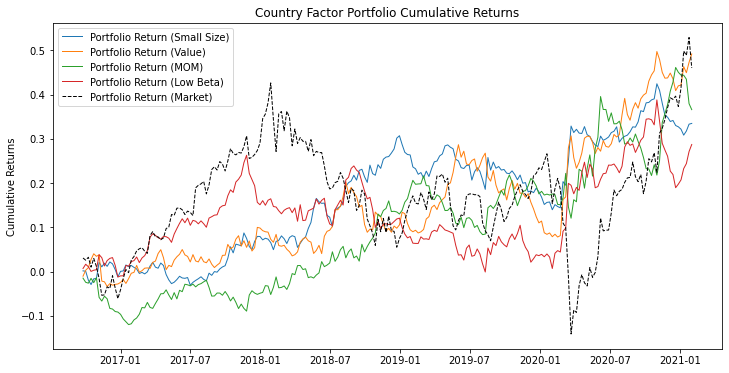

In [22]:
all_port_cum_ret_df = calc_cum_returns(all_port_rets)

# Plot cumulative returns
plot_perf(perf=[all_port_cum_ret_df[x] for x in list(all_port_cum_ret_df.columns.values)[:-1]], \
          perf_bm=all_port_cum_ret_df['market_cum_ret'], label=['Small Size', 'Value', 'MOM', 'Low Beta'], \
          title='Country Factor Portfolio Cumulative Returns')

In [23]:
all_perf = []
for col in all_port_rets.columns:
    perf_ = calc_performance(all_port_rets[col])
    all_perf.append(perf_)

perf_df = pd.DataFrame(all_perf, columns = ['Mean Return Ann. (%)', 'Std Ann. (%)', 'Sharpe Ratio Ann.', 'Skewness', 'Kurtosis', 'Max Drawdown (%)', 'Max Drawdown Date'], \
                       index = ['Small Size', 'Value', 'MOM', 'Low Beta', 'Market'])
perf_df

,Mean Return Ann. (%),Std Ann. (%),Sharpe Ratio Ann.,Skewness,Kurtosis,Max Drawdown (%),Max Drawdown Date
Small Size,6.60,9.77,4.87,0.94,2.55,12.80,2020-02-02
Value,10.07,11.74,6.18,0.54,4.13,16.22,2020-02-16
MOM,7.12,12.73,4.03,0.54,2.49,12.79,2020-10-18
Low Beta,5.87,12.05,3.52,0.69,3.21,20.89,2019-08-11
Market,8.45,20.52,2.97,-0.61,2.87,39.78,2020-03-22


## FF Factor Portfolio Returns

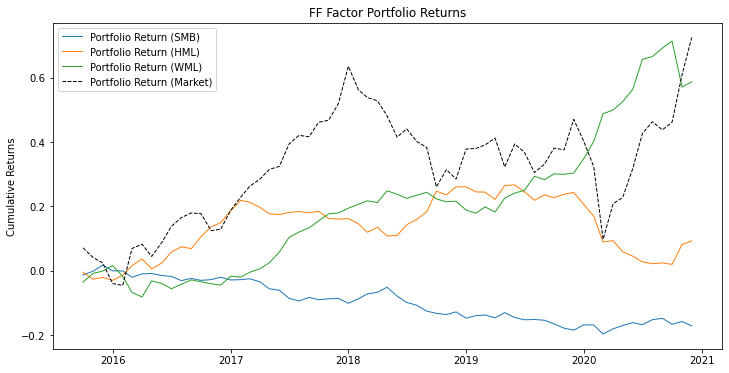

In [24]:
first_date = all_port_cum_ret_df.index[0]
ff6_ = ff6[ff6.index>=first_date]
all_ff_cum_ret_df = calc_cum_returns(ff6)

# Plot cumulative returns
plot_perf(perf=[all_ff_cum_ret_df[x] for x in list(all_ff_cum_ret_df.columns.values)[:-1]], \
          perf_bm=all_ff_cum_ret_df['Mkt-RF_cum_ret'], label=list(ff6.columns.values)[:-1], \
          title='FF Factor Portfolio Returns')

In [25]:
all_perf_ff = []
for col in ff6_.columns:
    perf_ff_ = calc_performance(ff6_[col], time = 12)
    all_perf_ff.append(perf_ff_)

perf_ff_df = pd.DataFrame(all_perf_ff, columns = ['Mean Return Ann. (%)', 'Std Ann. (%)', 'Sharpe Ratio Ann.', 'Skewness', 'Kurtosis', 'Max Drawdown (%)', 'Max Drawdown Date'], \
                       index = list(ff6_.columns.values))
perf_ff_df

,Mean Return Ann. (%),Std Ann. (%),Sharpe Ratio Ann.,Skewness,Kurtosis,Max Drawdown (%),Max Drawdown Date
SMB,-3.86,4.89,-2.73,-0.15,-0.77,18.01,2020-03-01
HML,0.52,7.89,0.23,-0.01,1.53,19.52,2020-10-01
WML,11.62,7.81,5.15,-1.17,6.11,8.36,2020-11-01
Mkt-RF,8.99,17.71,1.76,-1.03,3.02,32.91,2020-03-01
